<a href="https://colab.research.google.com/github/markotesic/ai-workforce-suitability/blob/main/Ability%20Profiles/Capability_profiles_all_items.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install 'pymc>5.9' --quiet
! pip install 'numpyro' --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 25.3 MB/s eta 0:00:00


In [2]:
import warnings

# Filter warnings for the specific library you want to suppress
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

import arviz as az
import numpy as np
import pandas as pd
import pickle
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, average_precision_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
#from tabpfn import TabPFNClassifier, TabPFNRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
plt.rcParams['figure.constrained_layout.use'] = True

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on xgboost v{xgb.__version__}")

Running on PyMC v5.26.1
Running on xgboost v3.1.0


In [3]:
!python --version

Python 3.12.12


In [4]:
all_annotations_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OECD capability profiles/all_annotations_for_selected_items.csv")

In [5]:
all_annotations_data.head()

,dataset name,sample id,Causal Reasoning,Cognitive Flexibility,Emotion Perception and Empathy,Episodic Memory,Functional Perception,Inhibitory Control,Language,Mental Simulation,Metacognition,Object Permanence,Perception and Pattern Recognition,Planning,Procedural Memory,Prospective Memory,Semantic Memory,Spatial Reasoning and Navigation,Theory of Mind,Working Memory
0,AGIEval_freeform,1,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,0.0,3.0,0.0,0.0,3.0
1,AGIEval_freeform,2,2.0,3.0,0.0,0.0,2.0,1.0,2.0,0.0,3.0,0.0,2.0,2.0,2.0,0.0,3.0,0.0,0.0,3.0
2,AGIEval_freeform,4,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,3.0,0.0,2.0,0.0,0.0,3.0
3,AGIEval_freeform,5,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0
4,AGIEval_freeform,6,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,3.0,1.0,3.0,0.0,3.0,1.0,0.0,3.0


# Demand correlations

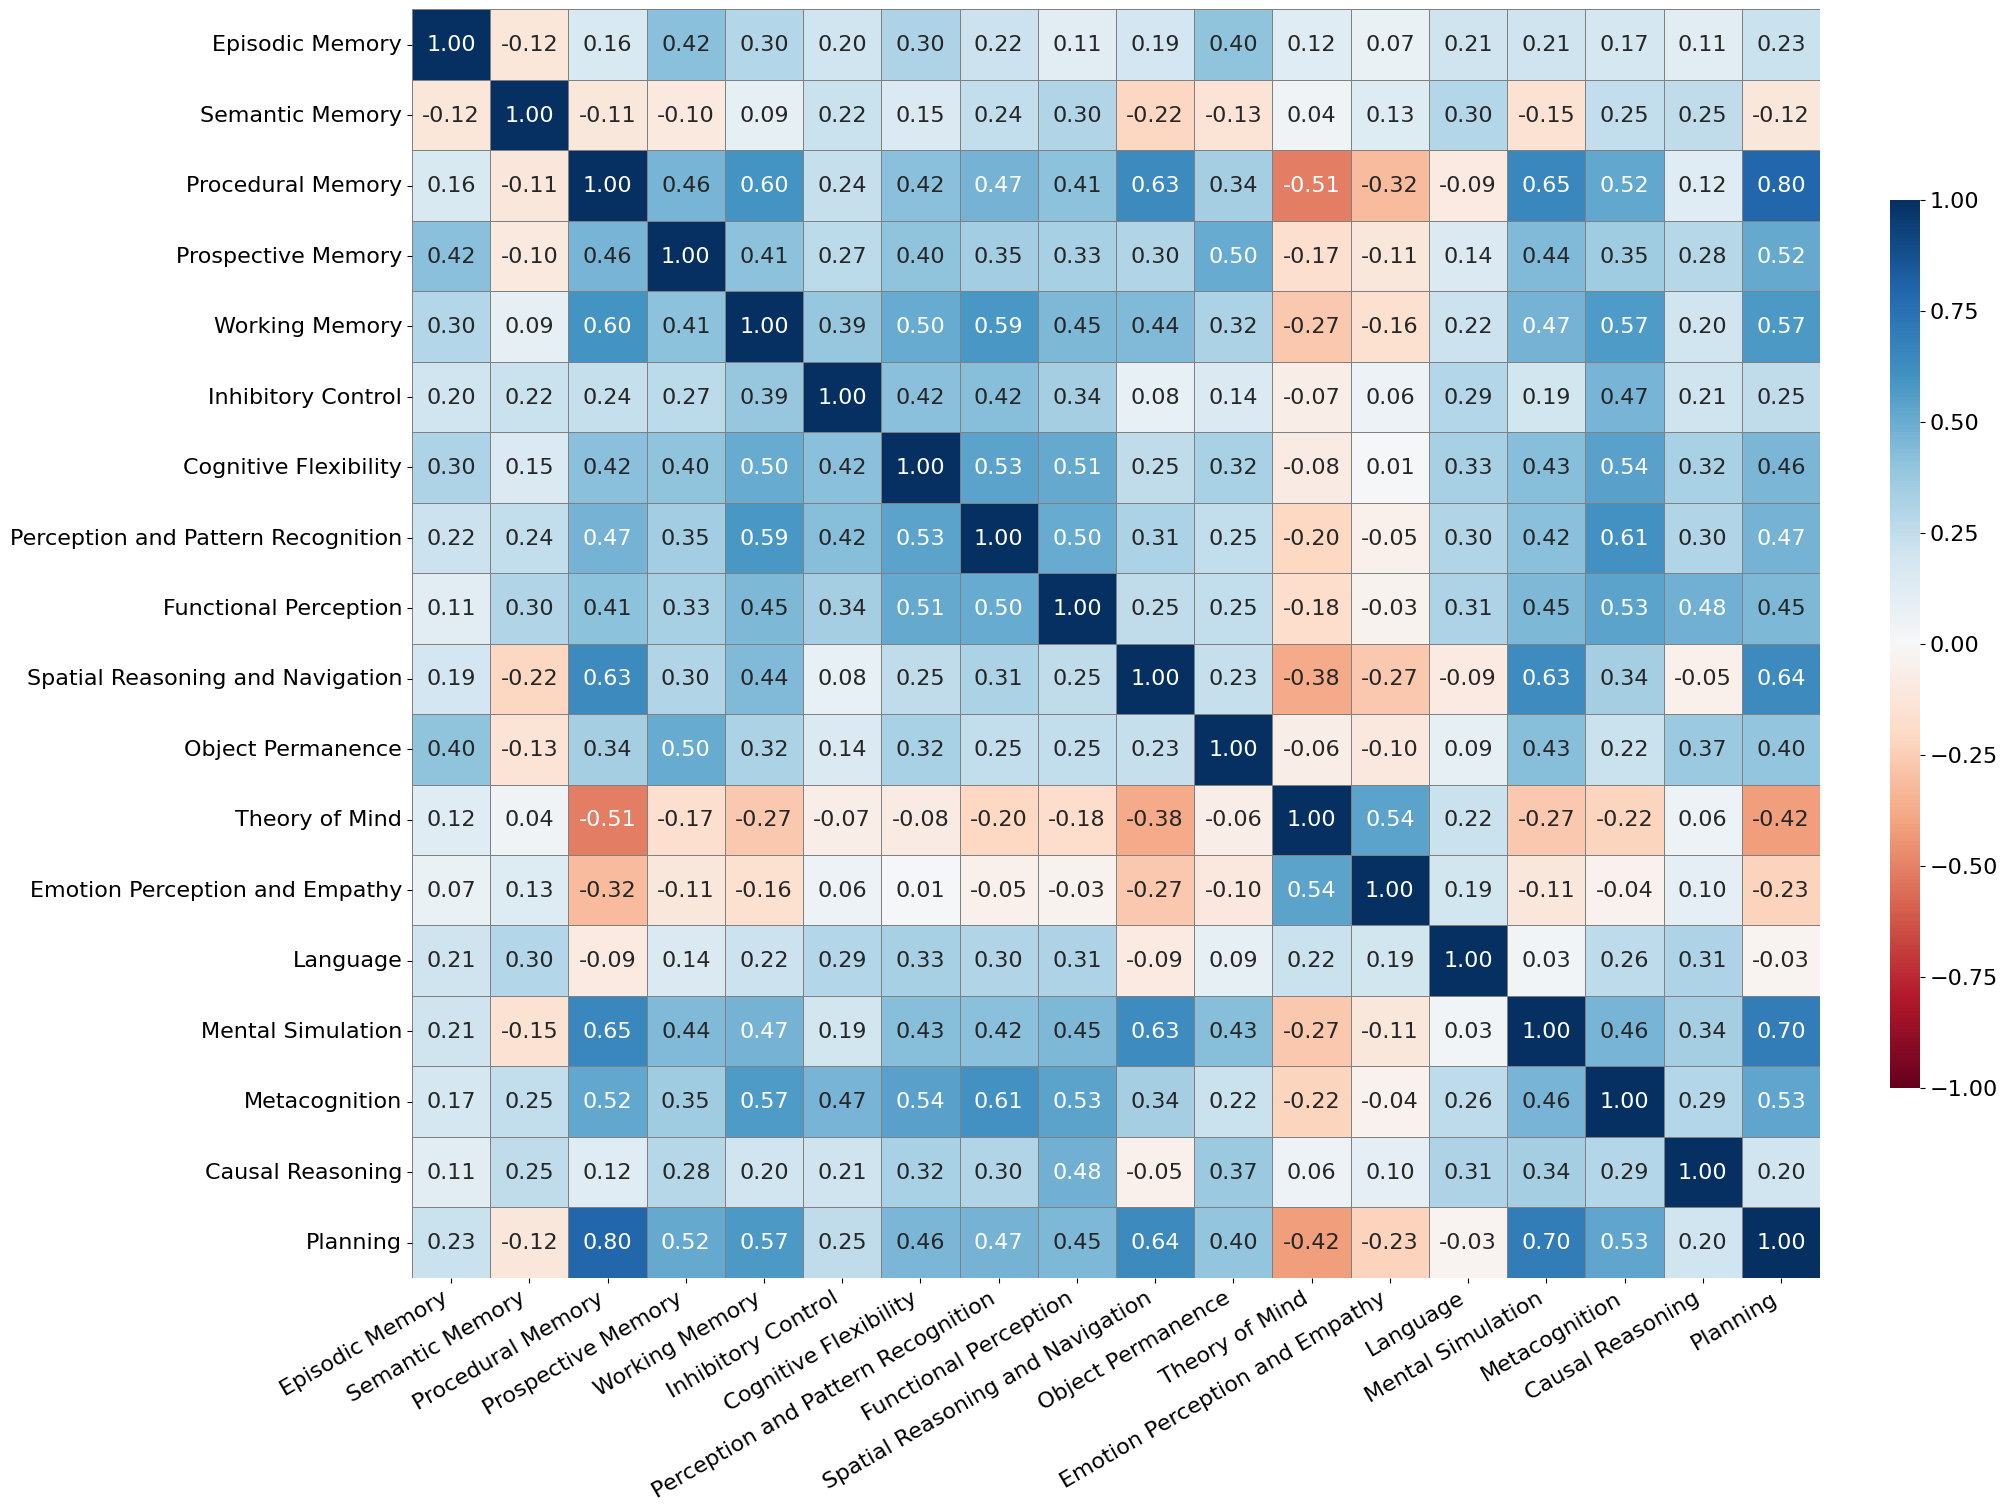

In [6]:
# Drop the specified columns and compute the correlation matrix
correlation_matrix = all_annotations_data.drop(columns=['dataset name', 'sample id']).corr()

# Define the desired order of columns
desired_order = [
    "Episodic Memory", "Semantic Memory", "Procedural Memory", "Prospective Memory", "Working Memory",
    "Inhibitory Control", "Cognitive Flexibility",
    "Perception and Pattern Recognition", "Functional Perception", "Spatial Reasoning and Navigation", "Object Permanence",
    "Theory of Mind", "Emotion Perception and Empathy",
    "Language", "Mental Simulation", "Metacognition",
    "Causal Reasoning", "Planning",
]

# Reindex the correlation matrix according to the desired order
correlation_matrix = correlation_matrix.reindex(index=desired_order, columns=desired_order)

plt.figure(figsize=(20, 15))  # Adjust figure size as needed
ax = sns.heatmap(correlation_matrix, cmap='RdBu', annot=True, fmt=".2f",
                 linewidths=.5, linecolor='gray', vmin=-1, vmax=1,
                 annot_kws={"size": 16}, cbar_kws={"shrink": 0.7, "aspect": 30})

# Make x and y labels bigger and rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

# Make color bar labels bigger and thinner
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
#cbar.ax.set_aspect(10) # Adjust aspect ratio to make it thinner

save = False
if save:
  filename = "/content/drive/MyDrive/Colab Notebooks/OECD capability profiles/demands_correlations.png"
  plt.savefig(filename, dpi=300, bbox_inches='tight')
#plt.title('Correlation Matrix of All Demands')
plt.show()

In [7]:
# Select the upper triangle of the correlation matrix, excluding the diagonal
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Stack the upper triangle to get a Series of correlations
stacked_correlations = upper_triangle.stack()

# Sort the correlations by absolute value in descending order and get the top 20
top_20_correlations = stacked_correlations.loc[stacked_correlations.abs().sort_values(ascending=False).head(20).index]

# Display the top 20 correlations
print("Top 20 Highest Absolute Correlations (showing original values):")
display(top_20_correlations)

Top 20 Highest Absolute Correlations (showing original values):


Procedural Memory                   Planning                              0.796789
Mental Simulation                   Planning                              0.700613
Procedural Memory                   Mental Simulation                     0.653544
Spatial Reasoning and Navigation    Planning                              0.637928
Procedural Memory                   Spatial Reasoning and Navigation      0.633958
Spatial Reasoning and Navigation    Mental Simulation                     0.626415
Perception and Pattern Recognition  Metacognition                         0.608700
Procedural Memory                   Working Memory                        0.596070
Working Memory                      Perception and Pattern Recognition    0.585253
                                    Planning                              0.572537
                                    Metacognition                         0.569746
Cognitive Flexibility               Metacognition                         0.540187
Theory of Mind                      Emotion Perception and Empathy        0.535114
Functional Perception               Metacognition                         0.534813
Cognitive Flexibility               Perception and Pattern Recognition    0.531408
Metacognition                       Planning                              0.529198
Procedural Memory                   Metacognition                         0.516222
Prospective Memory                  Planning                              0.515073
Cognitive Flexibility               Functional Perception                 0.509404
Procedural Memory                   Theory of Mind                       -0.509267
dtype: float64

In [8]:
# Compute the mean absolute correlation for each feature (excluding self-correlation)
mean_abs_corr = correlation_matrix.apply(lambda x: x.abs().sum() - 1, axis=1) / (len(correlation_matrix) - 1)

# Sort from most to least correlated overall
most_correlated = mean_abs_corr.sort_values(ascending=False)

# Display nicely
print("Average absolute correlation of each feature with all others:")
display(most_correlated.to_frame("mean_abs_corr"))

Average absolute correlation of each feature with all others:


,mean_abs_corr
Planning,0.411662
Procedural Memory,0.402500
Working Memory,0.383995
Mental Simulation,0.375367
Metacognition,0.375169
Perception and Pattern Recognition,0.367204
Cognitive Flexibility,0.351951
Functional Perception,0.346134
Prospective Memory,0.327366
Spatial Reasoning and Navigation,0.312193


- Theory of Mind seem to be negatively correlated with a lot of the demands, expect Emotion perception and empathy and Language. Moderately negatively correlated with Procedural memory and Planning (similar hold for Emotion Perception and Empathy).
- Emotion Perception and Empathy least correlated with other features, but exception is Theory of Mind
- Memory ones, not very correlated with each other (good thing I guess) expect Working memory and Procedural memory (which again makes sense).
- Procedural memory quite correlated (.8) with Planning and moderately correlated with Pental simulation and Spatial reasoning and navigation
- Perception and Pattern recognition moderately correlated with Metacognition
- Mental simulation moderately correlated with Procedural memory and Spatial reasoning and navigation and bit more correlated with Planning

# Simulate model performance  

For item $j$ with a $K$-dimensional demand vector $d_{j,\cdot}$ and a single agent with capability vector $c_{\cdot}$:

- Capabilities (log and interval scale): $c_k = \log \theta_k$ (what we infer).
- $\theta_k$: raw capability, on a ratio scale: $\theta_k = e^{c_k}$.
- Per-level multiplier: $\lambda_k$ (each +1 demand step on dim $k$ multiplies raw difficulty by $e^{\lambda_k}$).
- Margin (log-ratio evidence) per dimension:

$$m_{j,k} \;=\; c_k \;-\; \lambda_k\, d_{j,k}
\;=\; \log \frac{\theta_k}{\delta_{j,k}},\quad \delta_{j,k}=e^{\lambda_k d_{j,k}}$$
- $\delta_{j,k}$ is the raw difficulty on ratio scale (because it has an absolute 0 and multiplicative ratios are meaningful)

- Evidence weights (discriminations): $\kappa_k>0$.
- Total evidence/evidence pooling (log-odds):
$$\text{logit}(p_j) \;=\; \alpha \;+\; \sum_{k=1}^K \kappa_k\, m_{j,k}$$
- Success probability: $p_j=\sigma(\text{logit}(p_j))$
- Observed performance: $Y_j\sim\text{Bernoulli}(p_j)$

Notes:
- $\alpha$ is the intercept or baseline log-odds of success: When $\alpha = 0$ and when capability exactly matches demand on average (i.e. the sum of weighted differences = 0) the probability of success is: $p = \sigma(0) = 0.5$.
- $\kappa_k$ is discrimination parameter or evidence weight for capability $k$. It scales how much the difference between capability and demand (the margin) changes the log-odds of success. It's how “sensitive” success is to that particular capability. For instance, if $\kappa_k = 2$, then being one unit more capable than demanded ($c_k - \lambda_k d_{j,k} = 1$) increases log-odds of success by $+2$, or multiplies the odds by $e^{2} \approx 7.4$.
- If each demand step is $×e$ harder, set $\lambda_k=1$. For $×3$: $\lambda_k=\ln 3$; for $×10$: $\lambda_k=\ln 10$.
- Doubling the difficulty (i.e. $\delta_{j,k} → 2\delta_{j,k}$), changes the margin $m_{j,k}$ as:
$$\Delta m_{j,k} = \log\!\left(\frac{\theta_k}{2\delta_{j,k}}\right) - \log\!\left(\frac{\theta_k}{\delta_{j,k}}\right) = -\log 2.$$
So increasing difficulty by $×2$ reduces the margin (evidence) by $\log 2$. Change in log odds then is:
$$\Delta \text{logit}(p_j) = \sum_k \kappa_k \, \Delta m_{j,k} = -\kappa_{k} \log 2.$$

In terms of odds this is:

$$\frac{\text{odds}\text{new}}{\text{odds}\text{old}}
= e^{\Delta(\text{logit})}
= e^{-\kappa_k \log 2} = 2^{-\kappa_k}$$

So, doubling the difficulty divides the odds of success by $2^{\kappa_k}$


In [ ]:
import numpy as np
from scipy.special import expit as sigmoid  # logistic

def simulate_performance_optionC(
    C,        # (I,K) agent capability LEVELS c_ik  (log/interval scale)
    D,        # (J,K) item demands levels           (same scale as C)
    lam=1.0,  # scalar or (K,) per-level log step; lam=1 => ×e per level
    kappa=1.0,# scalar or (K,) discrimination weights
    alpha=0.0,# intercept (baseline log-odds when on-par)
    gamma0=None,     # fixed bonus to logits when an item has ALL demands == 0
    guess=None, slip=None,  # asymptotes: p = g + (1-g-s)*sigmoid(...)
    rng=None
):
    """
    Returns:
      Y : (I,J) simulated 0/1 outcomes
      p : (I,J) success probabilities
      z : (I,J) log-odds
    """
    rng = np.random.default_rng(rng)
    C = np.atleast_2d(np.asarray(C, float))      # (I,K)
    D = np.asarray(D, float)                     # (J,K)
    I, Kc = C.shape
    J, Kd = D.shape
    assert Kc == Kd, "C and D must have same K"

    lam   = np.broadcast_to(np.asarray(lam, float),   (Kd,))  # (K,)
    kappa = np.broadcast_to(np.asarray(kappa, float), (Kd,))  # (K,)

    # Margins m_{i j k} = c_{ik} - lam_k * D_{jk}
    # Shapes -> (I,1,K) - (1,J,K) = (I,J,K)
    # relevance mask: 1 if demand>0 else 0  (same shape as D, will broadcast)
    is_on = (D > 0).astype("float64")
    margin = is_on * (C[:, None, :] - (lam[None, None, :] * D[None, :, :]))

    # Total log-odds z_{i j} = alpha + sum_k kappa_k * margin_{i j k}
    z = alpha + np.sum(kappa[None, None, :] * margin, axis=2)  # (I,J)

    # Optional: make all-zero-demand items near-certain success
    if gamma0 is not None:
        all_zero = (D == 0).all(axis=1).astype(float)          # (J,)
        z = z + gamma0 * all_zero[None, :]

    # Probabilities with optional guessing/slip asymptotes
    p_base = sigmoid(z)
    if (guess is not None) or (slip is not None):
        g = 0.0 if guess is None else float(guess)
        s = 0.0 if slip  is None else float(slip)
        p = g + (1 - g - s) * p_base
    else:
        p = p_base

    # Sample outcomes
    Y = rng.binomial(1, p)
    return Y, p, z

In [ ]:
# Example setup
J, K = 30, 4
D = np.random.randint(0, 6, size=(J, K))  # demands 0..5

# 1) Single agent with moderate capabilities
c_agent = np.array([3.0, 2.5, 3.5, 2.0])  # capability levels
Y, p, z = simulate_performance_optionC(
    C=c_agent, D=D, lam=1.0, kappa=1.0, alpha=0.0, gamma0=8.0, rng=1
)

# 2) Multiple agents (generalist, specialist, weaker)
C = np.vstack([
    [3.0, 3.0, 3.0, 3.0],   # generalist
    [4.0, 1.5, 4.0, 1.5],   # specialist (strong on 0 and 2)
    [2.0, 2.0, 2.0, 2.0],   # weaker generalist
])
Y_multi, p_multi, _ = simulate_performance_optionC(
    C=C, D=D, lam=np.log(3), kappa=[1.0, 0.8, 1.2, 0.9], alpha=0.0, rng=2
)

# 3) Add a guessing floor (e.g., 4-choice MCQ)
Y_g, p_g, _ = simulate_performance_optionC(
    C=c_agent, D=D, lam=1.0, kappa=1.0, alpha=0.0, guess=0.25, rng=3
)

In [ ]:
import pymc as pm
import numpy as np
import aesara.tensor as at

def build_single_agent_optionC(
    Y,                # (J,) binary performance for one agent (0/1)
    D,                # (J, K) item demands, levels in {0..5} (or floats)
    *,
    lam=1.0,          # per-level log step; scalar or (K,). lam=1 => ×e per level
    mu_c=3.0, sigma_c=1.0,    # priors for capability levels c[k]
    alpha_prior=(0.0, 1.0),   # prior for intercept α: Normal(mean, sd)
    kappa_sd=1.0,             # HalfNormal sd for κ[k] (scalar or (K,))
    gamma0=None,              # optional fixed boost on logits when ALL demands=0 for an item
    guess=None, slip=None     # optional asymptotes: p = g + (1-g-s)*σ(...)
):
    Y = np.asarray(Y).astype("int8")
    D = np.asarray(D, dtype=float)
    J, K = D.shape

    # allow vector hyperparams
    lam = np.full(K, float(lam)) if np.isscalar(lam) else np.asarray(lam, float)
    kappa_sd = np.full(K, float(kappa_sd)) if np.isscalar(kappa_sd) else np.asarray(kappa_sd, float)

    with pm.Model() as m:
        # latent capabilities on the same *level* ruler as D
        c = pm.Normal("c", mu=mu_c, sigma=sigma_c, shape=K)          # capability levels (log-scale)
        theta = pm.Deterministic("theta", pm.math.exp(c))            # ratio-scale capability, for reporting

        # evidence weights (discriminations)
        kappa = pm.HalfNormal("kappa", sigma=kappa_sd, shape=K)

        # intercept (prior log-odds at "on-par")
        alpha = pm.Normal("alpha", mu=alpha_prior[0], sigma=alpha_prior[1])

        # shared demands
        d = pm.Data("d", D)                                          # (J,K)


        is_on = at.gt(d, 0).astype("float64")           # 1 if demand>0 else 0
        # margins = log-ratios: m[j,k] = c[k] - lam[k]*d[j,k]
        margin = is_on * (c[None, :] - lam[None, :] * d)                     # (J,K)

        # total evidence in log-odds space
        z = pm.Deterministic("z_logit", alpha + at.sum(kappa[None, :] * margin, axis=1))  # (J,)

        # optional boundary: items with ALL demands==0 => near-certain success
        if gamma0 is not None:
            all_zero = at.eq(at.sum(at.eq(d, 0), axis=1), K).astype("float64")            # (J,)
            z = z + gamma0 * all_zero

        # probability (optionally with guessing/slip asymptotes)
        if (guess is not None) or (slip is not None):
            g = 0.0 if guess is None else float(guess)
            s = 0.0 if slip  is None else float(slip)
            p = pm.Deterministic("p", g + (1 - g - s) * pm.math.sigmoid(z))
        else:
            p = pm.Deterministic("p", pm.math.sigmoid(z))

        # likelihood
        pm.Bernoulli("y", p=p, observed=Y)

    return m

In [ ]:
# Y: shape (J,), D: shape (J,K)
m = build_single_agent_optionC(
    Y, D,
    lam=1.0,            # ×e per level (use np.log(3) for ×3, etc.)
    mu_c=3.0, sigma_c=1.0,
    alpha_prior=(0.0, 1.0),
    kappa_sd=1.0,
    gamma0=8.0          # optional, if some items truly have all-zero demands
)
with m:
    idata = pm.sample(tune=1000, draws=1000, target_accept=0.9, random_seed=42)

# After sampling:
# idata.posterior["c"]  -> capability levels (same ruler as D)
# idata.posterior["theta"] -> ratio-scale capabilities
# idata.posterior["kappa"], ["alpha"], ["p"] -> interpretable parameters & predicted probs